In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import bayesnewton
import matplotlib.cm as cm
import time
import objax
from tqdm.notebook import trange, tqdm

rng = np.random.RandomState(123)

## Data

### Temperature

In [2]:
%%time

ds = xr.tutorial.open_dataset("air_temperature").load()

CPU times: user 645 ms, sys: 185 ms, total: 831 ms
Wall time: 6.86 s


In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

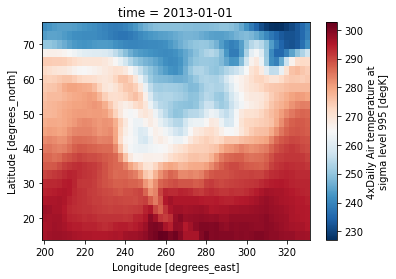

In [4]:
ds.air.isel(time=0).plot(cmap="RdBu_r")

In [5]:
subset_ds = ds.isel(
    time=slice(0, 50), 
    # lat=slice(-50, 10), 
    # lon=slice(-50, 20)
)
subset_ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 50, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-13T06:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 297.4 297.3 297.2
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

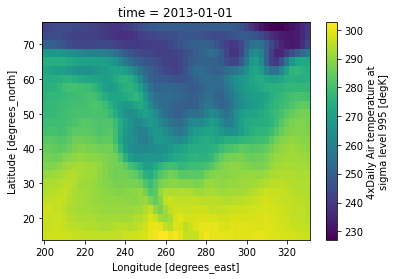

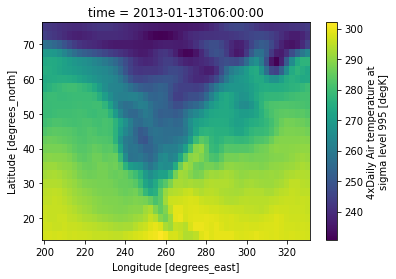

In [6]:
subset_ds.air.isel(time=0).plot()
plt.show()
subset_ds.air.isel(time=49).plot()
plt.show()

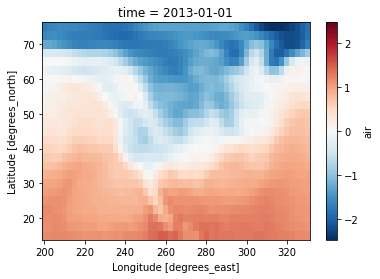

In [7]:
# remove mean and divide by SDE

mean = subset_ds.air.mean(axis=(1,2))
std = subset_ds.air.std(axis=(1,2))

dat = (subset_ds.air - mean) / std
dat.isel(time=0).plot()

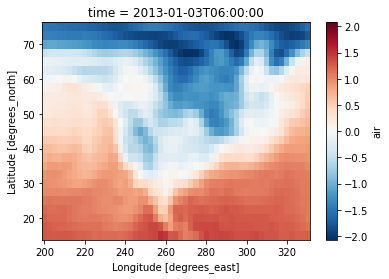

In [8]:
dat.isel(time=9).plot()

## Dataset Dimensions

* Latitude 
* Longitude
* Total Spatial Dims
* Time
* Total Dims
* Total Variables

In [9]:
# number of time
nt = dat.time.shape[0]

# spatial dimensions
n_lat = dat.lat.shape[0]
n_lon = dat.lon.shape[0]
n_latlon = n_lat * n_lon
n_coords = 2

# variable dimensions
n_vars = 1

In [10]:
n_dims = n_vars * n_latlon * nt

print(f"Total Dims: {n_dims:,}")

Total Dims: 66,250


In [11]:
# N = Y_obs.shape[0] * Y_obs.shape[1] * Y_obs.shape[2]

# print(f"Num data points: {N:,}")

In [12]:
data = dat.to_dataframe().reset_index()
data.head()

,time,lat,lon,air
0,2013-01-01,75.0,200.0,-1.725644
1,2013-01-01,75.0,202.5,-1.657594
2,2013-01-01,75.0,205.0,-1.605249
3,2013-01-01,75.0,207.5,-1.579076
4,2013-01-01,75.0,210.0,-1.573842


### Train Split

In [13]:
# create random test indices
test_ind = rng.permutation(n_dims)[:n_dims//10]


# data_train = 

In [14]:
# nd = subset_ds.shape[0]

In [15]:
# binsize (delta t)
binsize = 1000 / nt

In [16]:
# subset_ds.air.shape, time_stamp.shape, lat.shape, lon.shape

In [17]:
Y = data["air"].values
time_stamp = data["time"].view(np.int64) // 10 ** 9
lat = data["lat"].values
lon = data["lon"].values
X = np.stack([time_stamp, lat, lon], axis=1)
Y.shape, X.shape

((66250,), (66250, 3))

In [25]:
X[..., 2]

array([200. , 202.5, 205. , ..., 325. , 327.5, 330. ])

In [18]:
t, R_plot, Y_obs_plot = bayesnewton.utils.create_spatiotemporal_grid(X, Y)

In [19]:
t.shape, R_plot.shape, Y_obs_plot.shape

((50, 1), (50, 1325, 2), (50, 1325, 1))

#### Sequential

In [19]:
t = X[:, :1]
R = X[:, 1:]
t.shape, R.shape, Y.shape

((66250, 1), (66250, 2), (66250,))

In [20]:
Nt = t.shape[0]
print("num time steps =", Nt)
N = Y_obs_plot.shape[0] * Y_obs_plot.shape[1] * Y_obs_plot.shape[2]
print("num data points =", N)

num time steps = 66250
num data points = 66250


In [21]:
Y.shape

(66250,)

In [22]:
# sort out the train/test split
fold = 0
np.random.seed(99)
ind_shuffled = np.random.permutation(N)
ind_split = np.stack(np.split(ind_shuffled, 10))  # 10 random batches of data indices
test_ind = ind_split[fold]  # test_ind = np.random.permutation(N)[:N//10]
X_test = X[test_ind]
Y_test = Y[test_ind]
Y[test_ind] = np.nan
# Y = Y.reshape(nt, nr)

#### Gridded

In [23]:
%%time

t_train, R_train, Y_obs_train = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
t_test, R_test, Y_obs_test = bayesnewton.utils.create_spatiotemporal_grid(X_test, Y_test)

CPU times: user 422 ms, sys: 31.2 ms, total: 453 ms
Wall time: 430 ms


In [24]:
# assert t.shape == (nt, 1)
# assert R.shape == (nt, n_d, n_coords)
# assert Y_obs.shape == (nt, n_d, n_vars)

In [25]:
test_ind.shape, R.shape

((6625,), (66250, 2))

### Sparse Points

In [26]:
z1 = np.linspace(np.min(X[:,1]), np.max(X[:, 1]), num=7)
z2 = np.linspace(np.min(X[:,2]), np.max(X[:, 2]), num=7)

zA, zB = np.meshgrid(z1, z2)

z = np.hstack((zA.reshape(-1, 1), zB.reshape(-1, 1)))

In [27]:
z.shape, R[0, ...].shape

((49, 2), (2,))

In [28]:
var_f = 1.  # GP variance
len_f = 1.  # lengthscale
len_time = 1
len_space = 1
sparse = True
opt_z = True

In [29]:
# kernel
kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

In [30]:
kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='Full')

In [32]:
%%time

# likelihood
lik = bayesnewton.likelihoods.Gaussian(variance=1)

# model
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t_train, R=R_train, Y=Y_obs_train, parallel=False)
# model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y_obs, parallel=False)
# model = bayesnewton.models.SparseMarkovGaussianProcess(kernel=kern, likelihood=lik, X=t, R=R, Y=Y_obs, Z=z)
# model = bayesnewton.models.SparseMarkovMeanFieldGaussianProcess(kernel=kern, likelihood=lik, X=t, R=R, Y=Y_obs)


/Users/eman/miniconda3/envs/eo_mgp/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5269: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


CPU times: user 34.2 s, sys: 7.48 s, total: 41.7 s
Wall time: 15.4 s


In [33]:
lr_adam = 0.1
lr_newton = 1.0
iters = 1_000
opt_hypers = objax.optimizer.Adam(model.vars())

In [34]:
energy = objax.GradValues(model.energy, model.vars())

In [35]:
@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    # test_nlpd_ = model.negative_log_predictive_density(X=t_test, R=r_test, Y=Y_test)
    return E


train_op = objax.Jit(train_op)

In [36]:
t0 = time.time()

losses = []

with trange(1, iters + 1) as pbar:
    for i in pbar:
        loss = train_op()

        losses.append(np.array(loss[0]))
        
        pbar.set_description(f"iter {i:d}, energy: {loss[0]:1.4f}")
        
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

  0%|          | 0/1000 [00:00<?, ?it/s]

2021-12-15 22:29:27.008519: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module jit_jit.13157
********************************
2021-12-15 22:30:19.270604: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module jit_jit__1.13139
********************************


KeyboardInterrupt: 

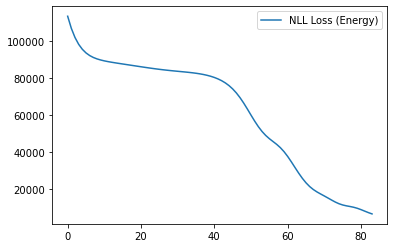

In [37]:
fig, ax = plt.subplots()

ax.plot(losses, label="NLL Loss (Energy)")
plt.legend()
plt.show()

In [38]:
N_test = 50

# r1 = np.unique(X[:, 1])
# r2 = np.unique(X[:, 2])
X1range = max(X[:, 1]) - min(X[:, 1])
X2range = max(X[:, 2]) - min(X[:, 2])
r1 = np.linspace(min(X[:, 1]) - 0.1 * X1range, max(X[:, 1]) + 0.1 * X1range, num=N_test)
r2 = np.linspace(min(X[:, 2]) - 0.05 * X2range, max(X[:, 2]) + 0.05 * X2range, num=N_test)
rA, rB = np.meshgrid(r1, r2)
r = np.hstack((rA.reshape(-1, 1), rB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
Rplot = np.tile(r, [t.shape[0], 1, 1])


In [39]:
Rplot.shape, t.shape

((66250, 2500, 2), (66250, 1))

In [40]:
%%time

posterior_mean, posterior_var = model.predict(X=t_train, R=R_train)

CPU times: user 20.8 s, sys: 22 s, total: 42.9 s
Wall time: 21 s


In [41]:
posterior_mean.shape

(50, 1325)

In [46]:
# mu = bayesnewton.utils.transpose(posterior_mean.reshape(-1, N_test, N_test))
mu = bayesnewton.utils.transpose(posterior_mean.reshape(-1, n_lat, n_lon))
mu_real = bayesnewton.utils.transpose(Y_obs_train.reshape(-1, n_lat, n_lon))

In [45]:
mu.shape, Y_obs_train.shape

((50, 53, 25), (50, 1325, 1))

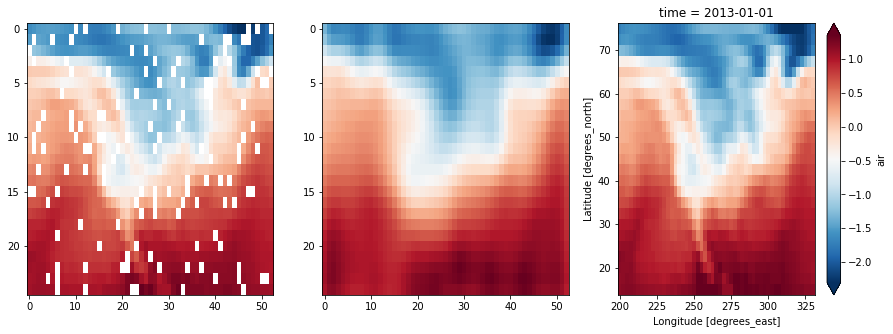

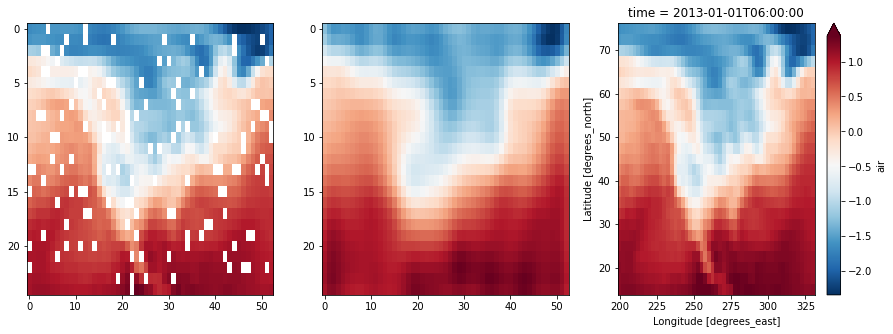

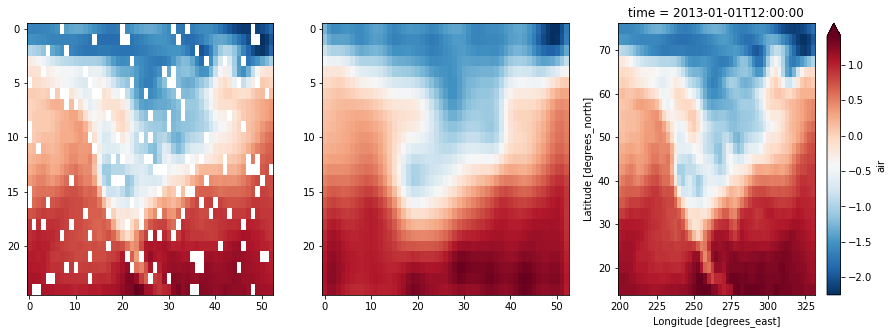

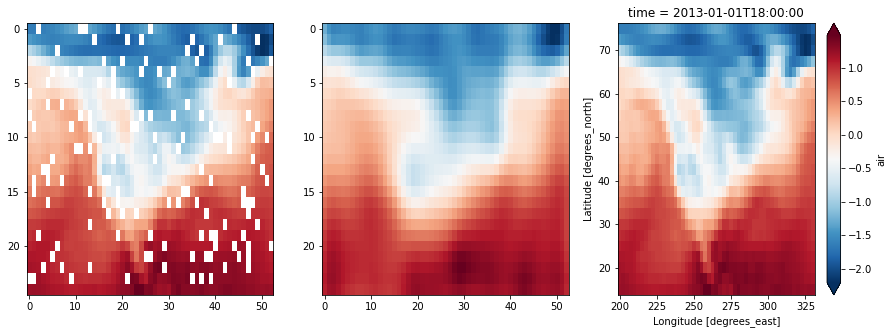

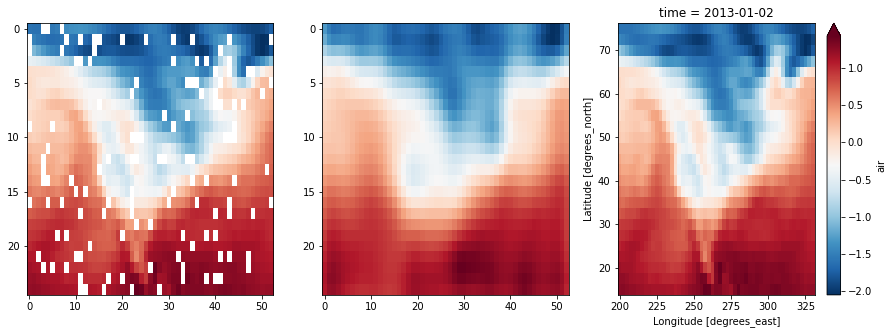

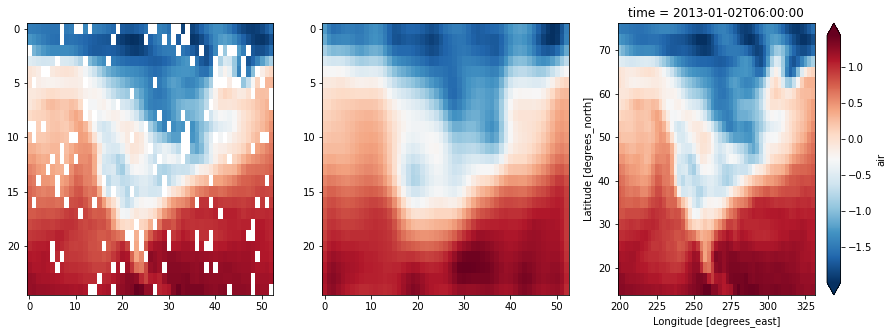

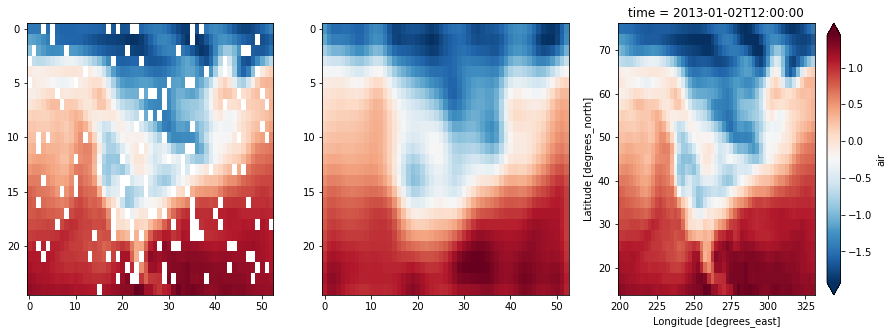

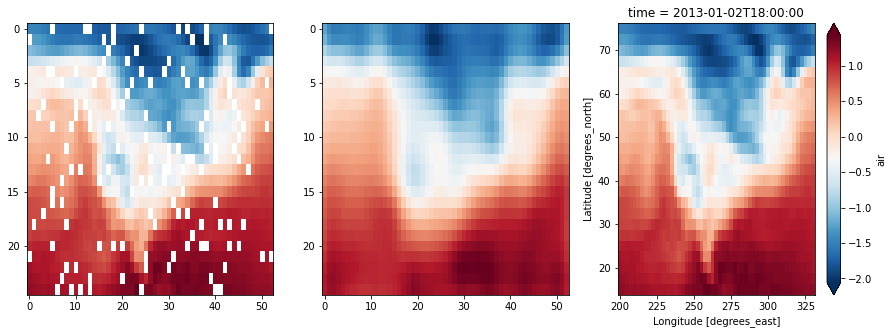

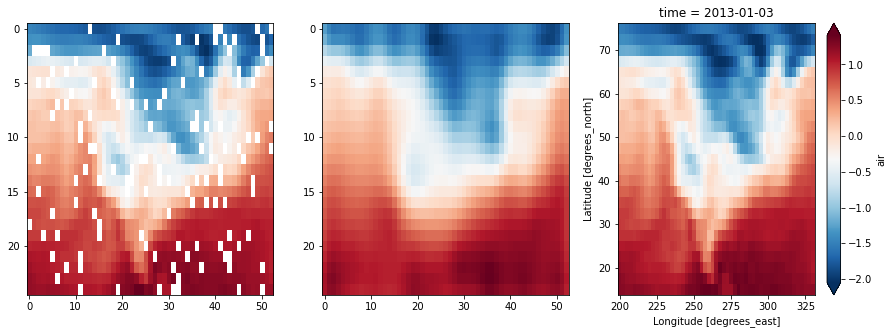

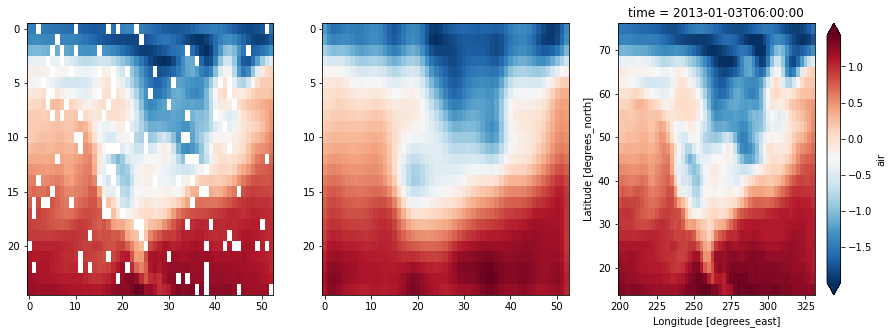

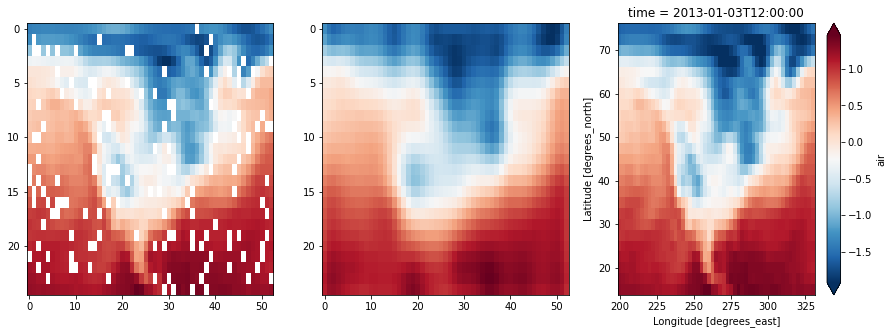

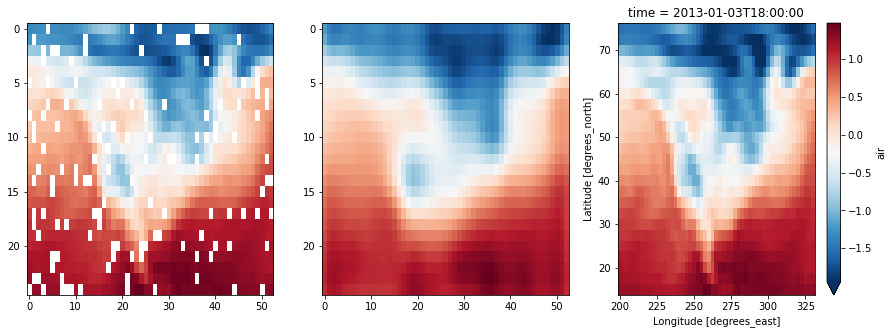

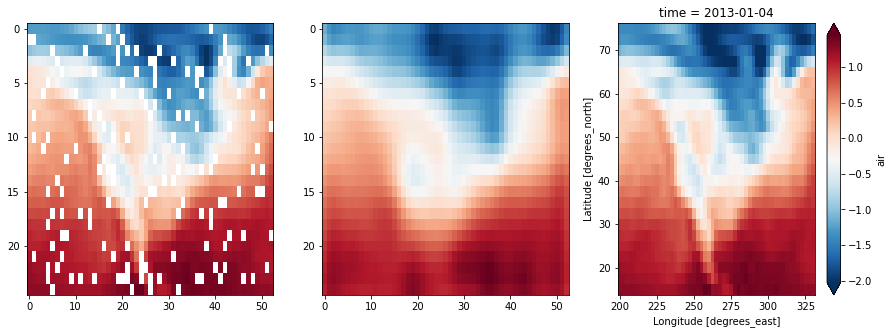

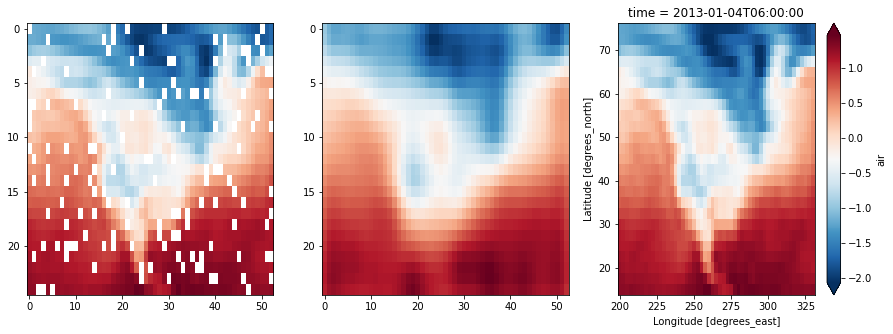

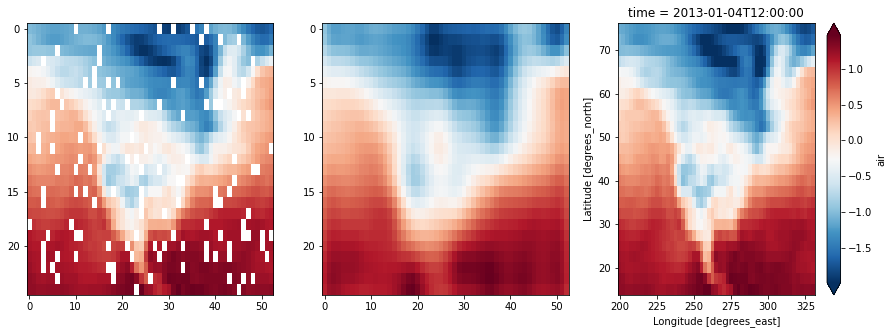

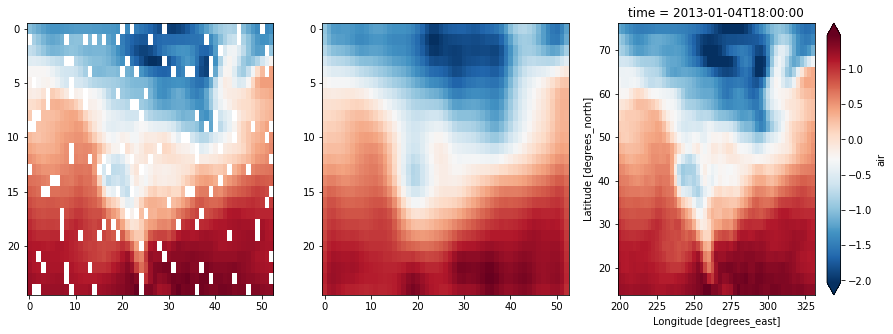

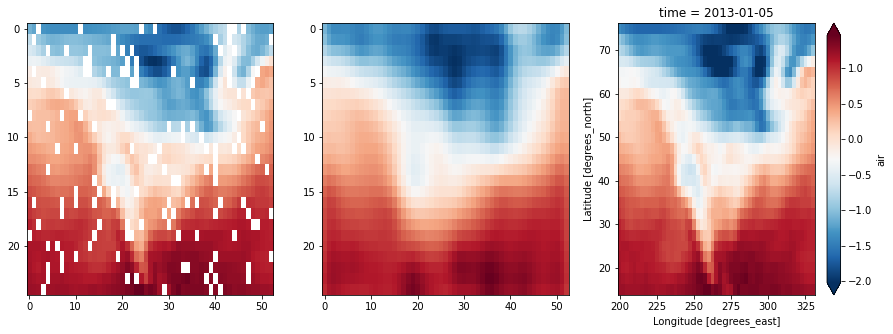

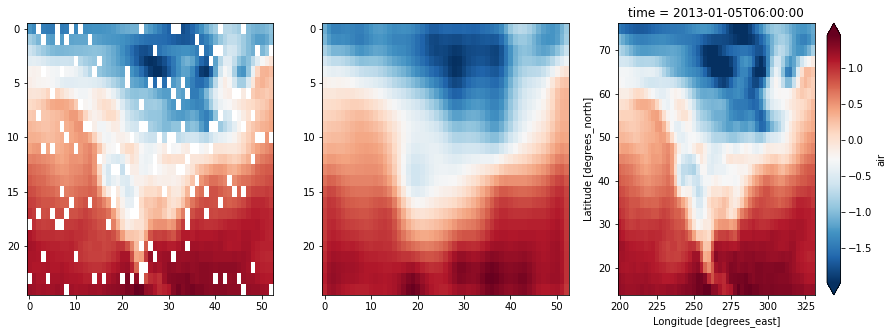

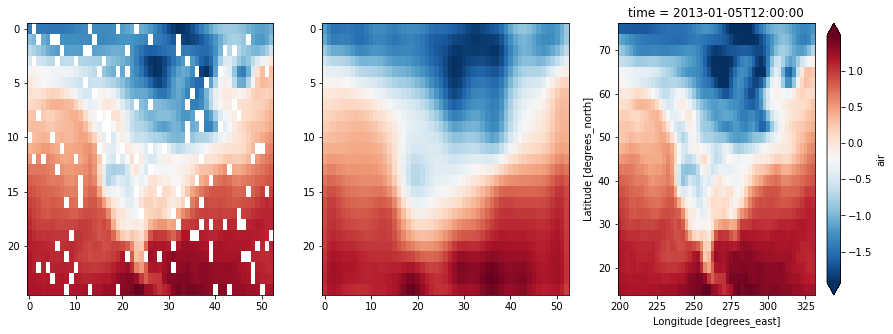

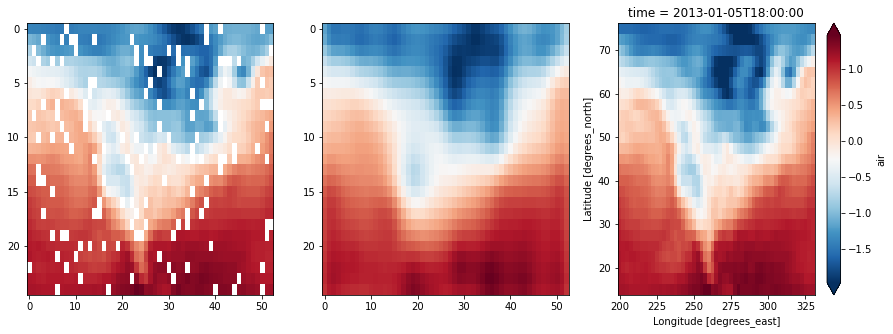

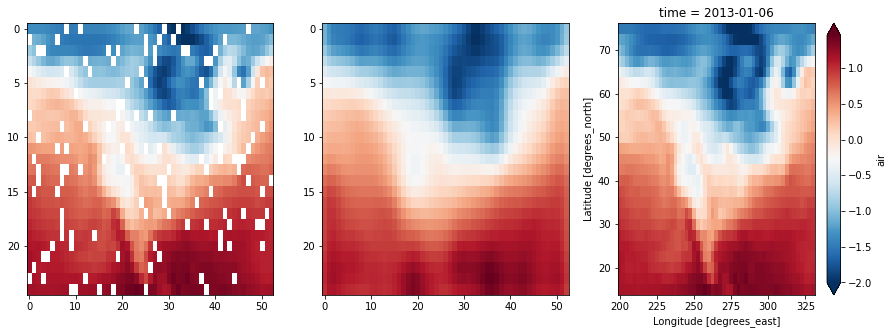

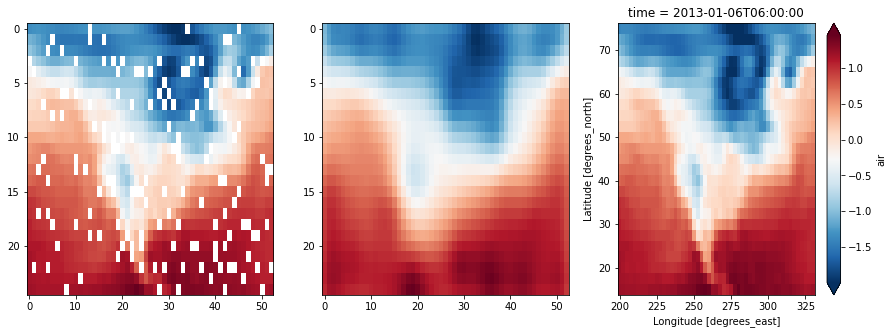

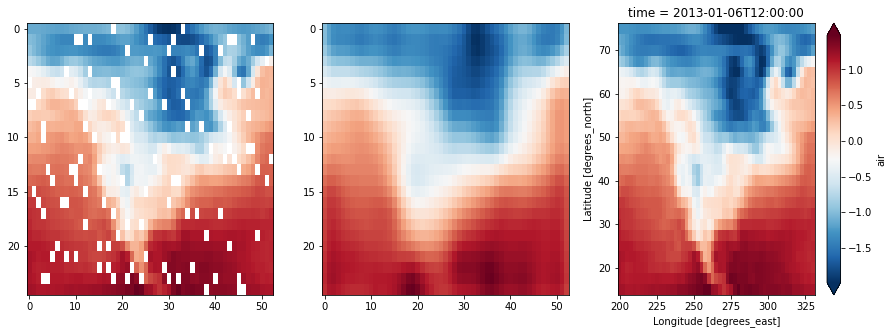

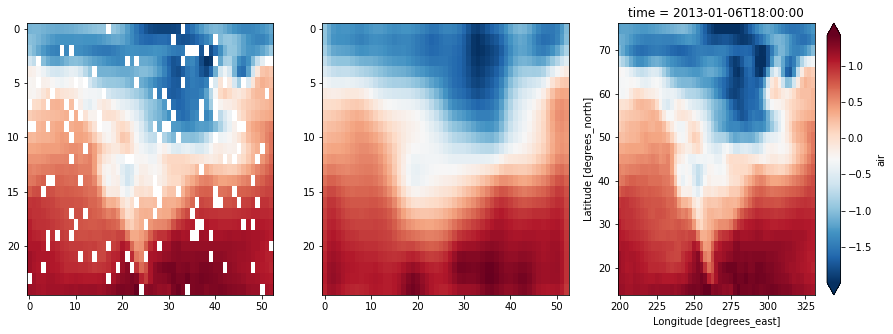

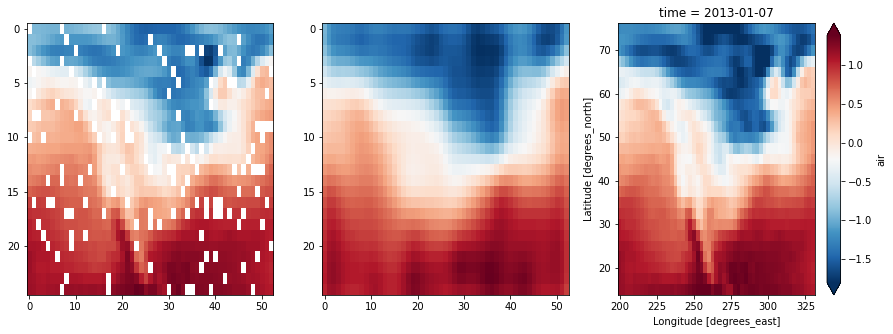

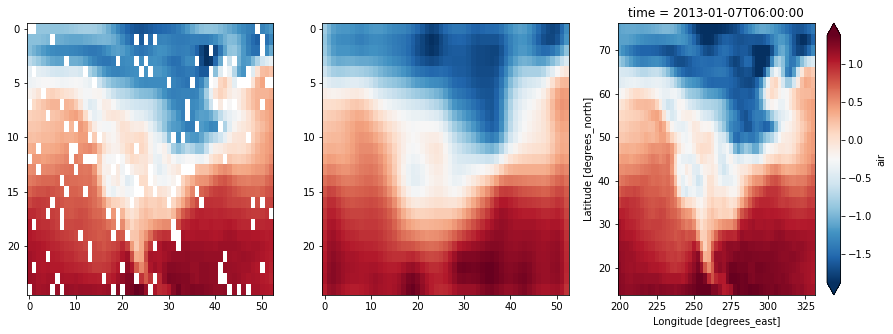

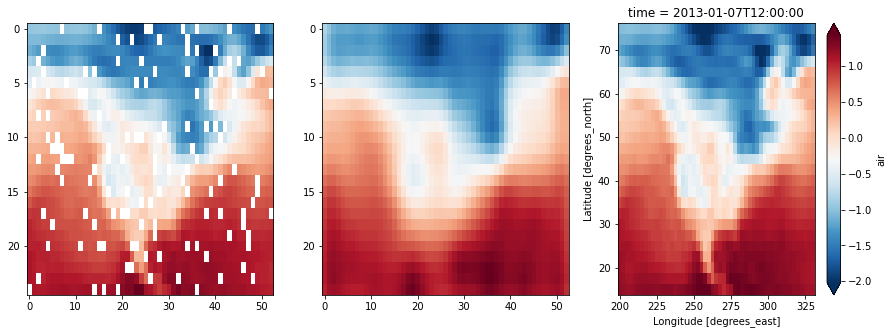

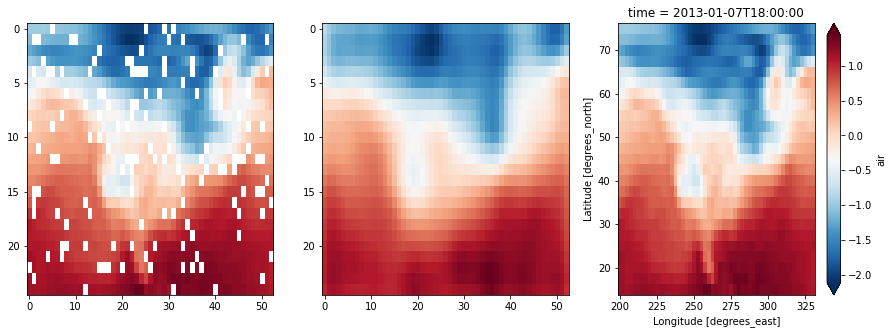

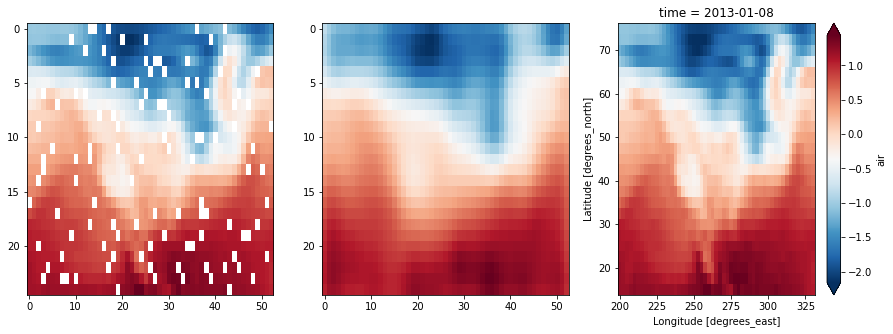

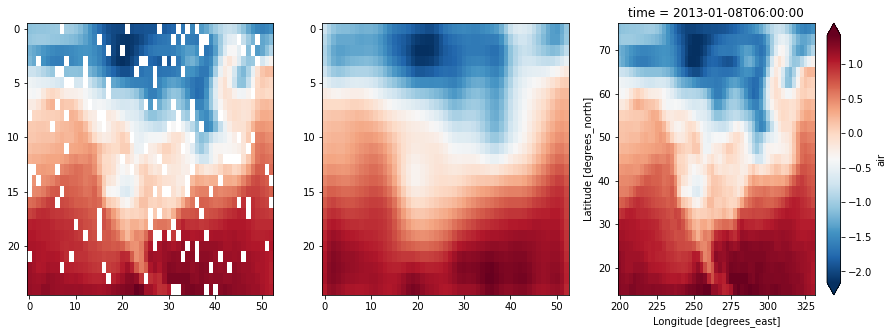

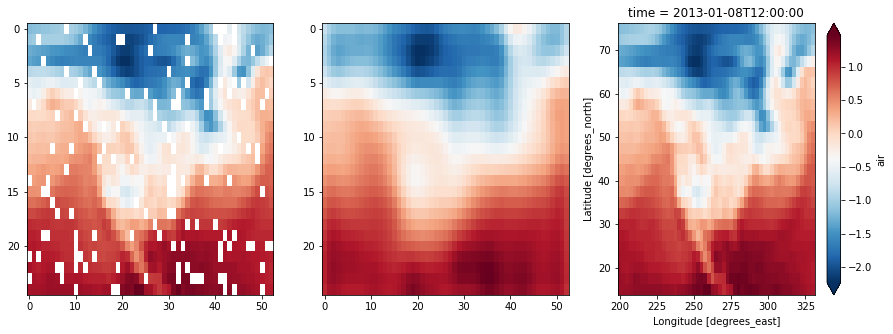

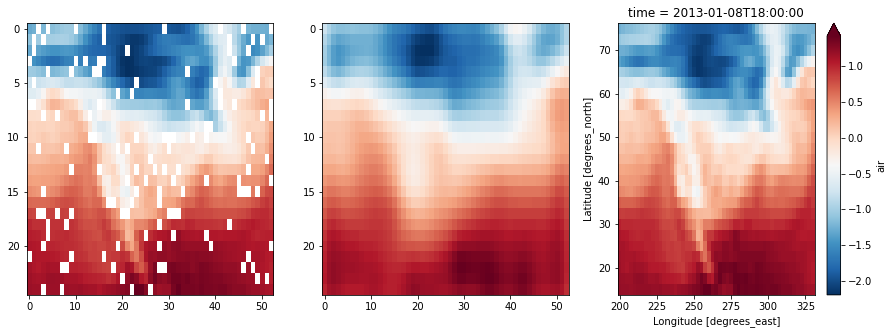

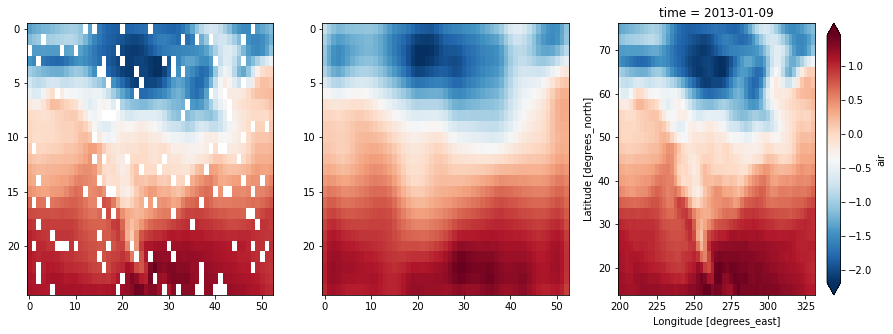

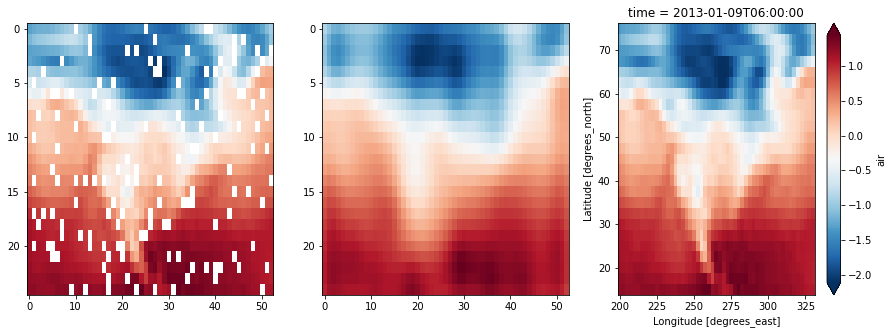

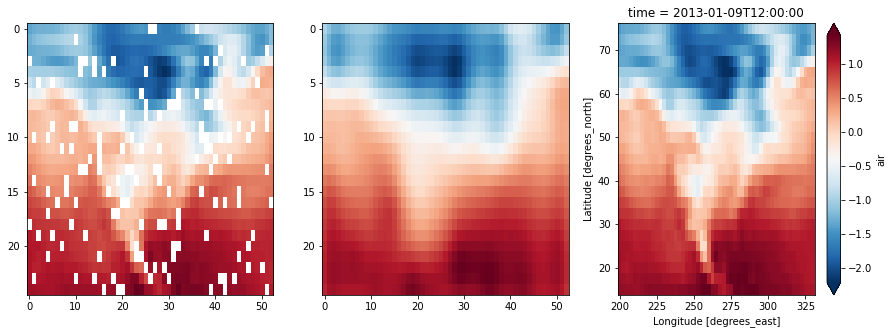

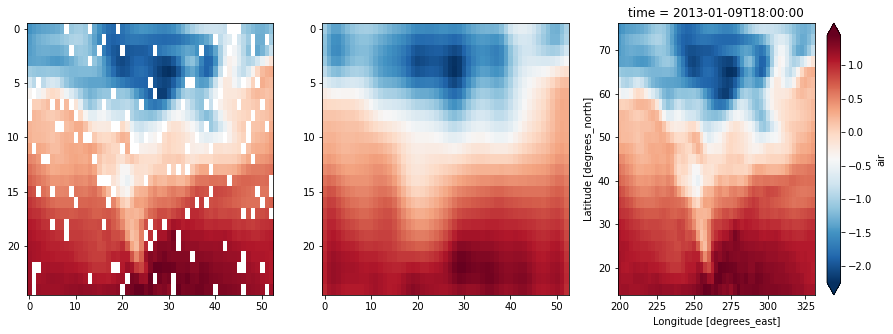

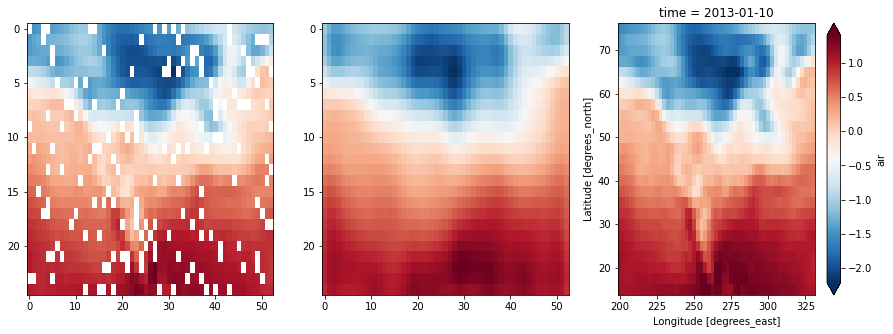

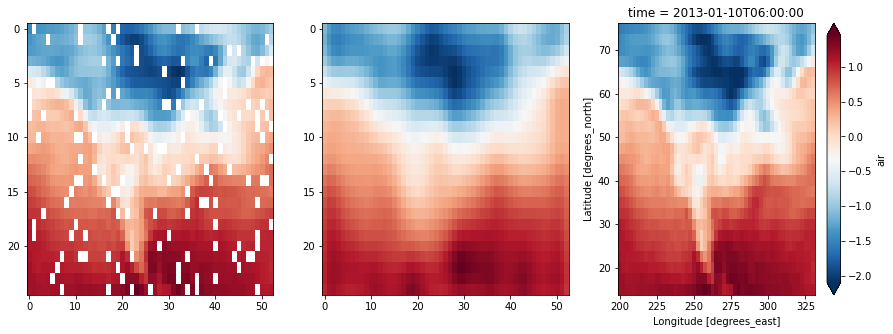

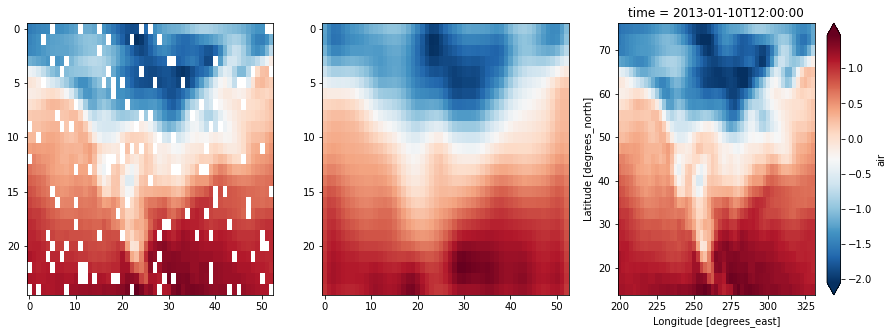

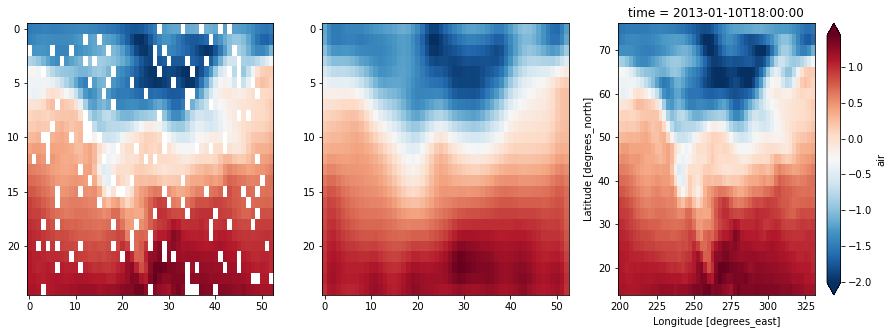

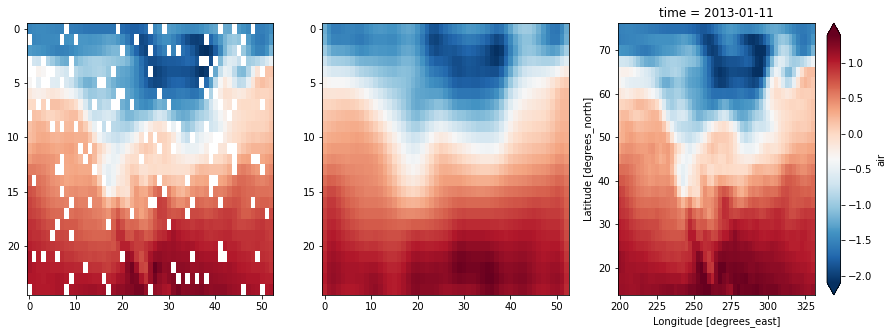

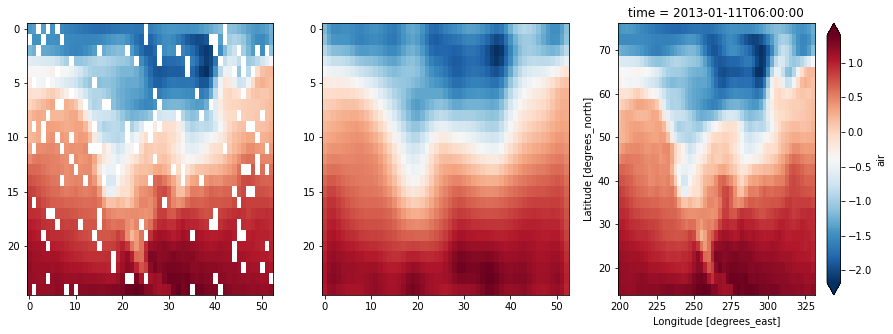

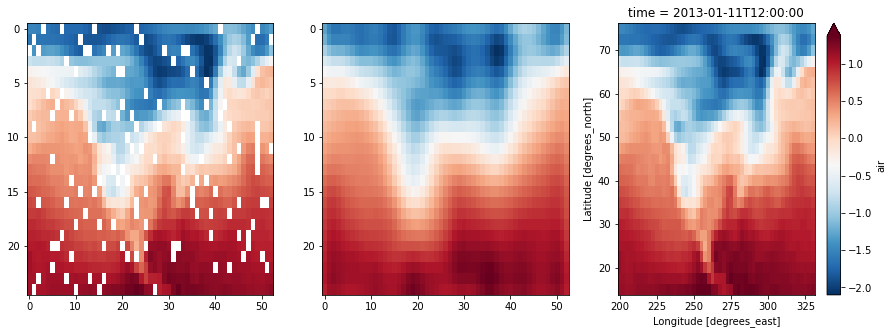

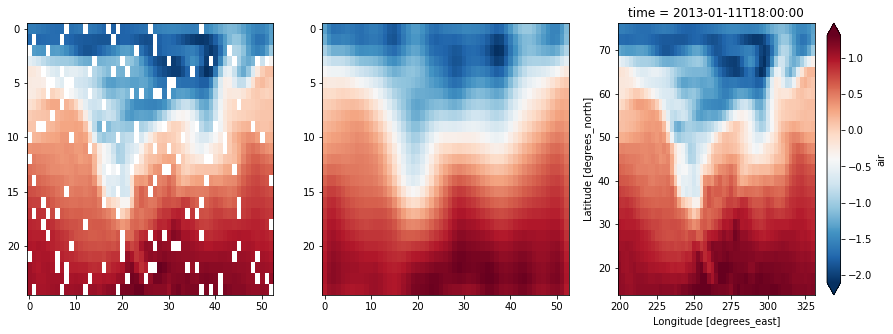

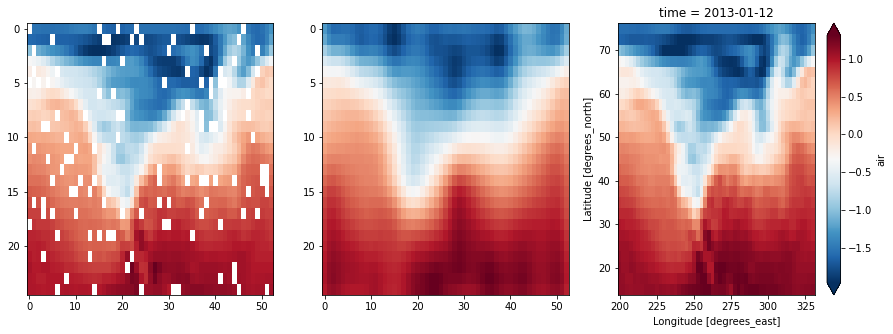

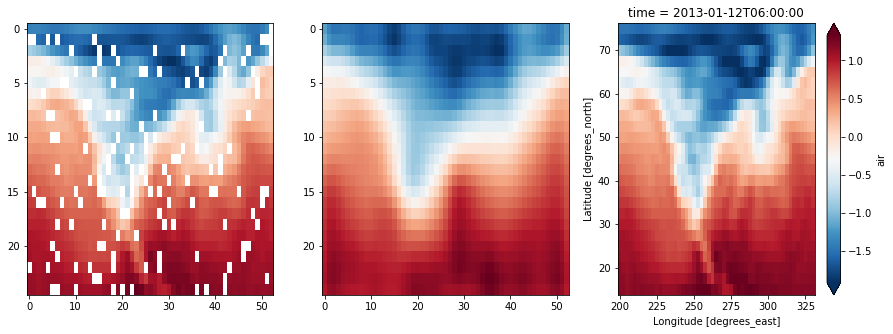

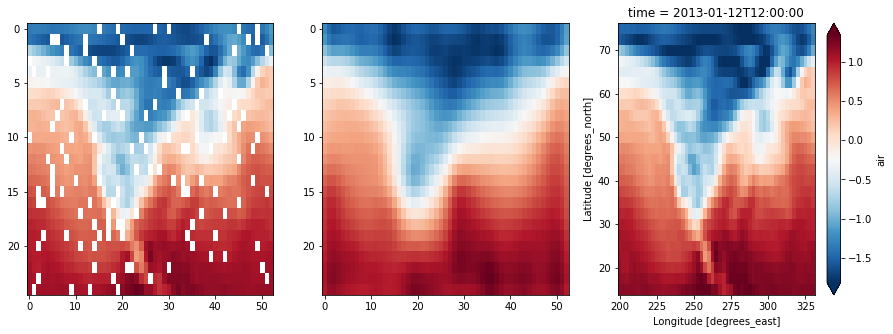

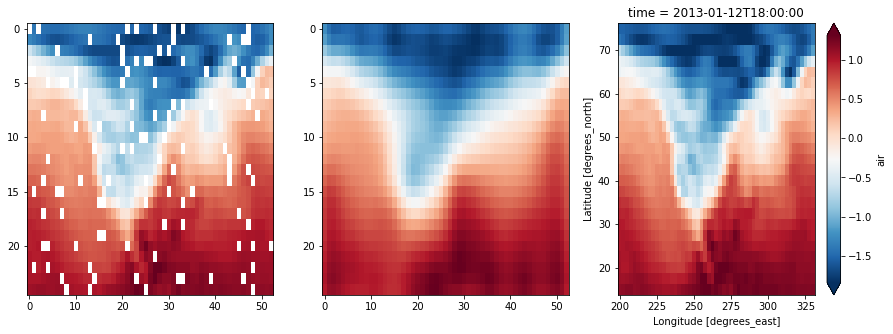

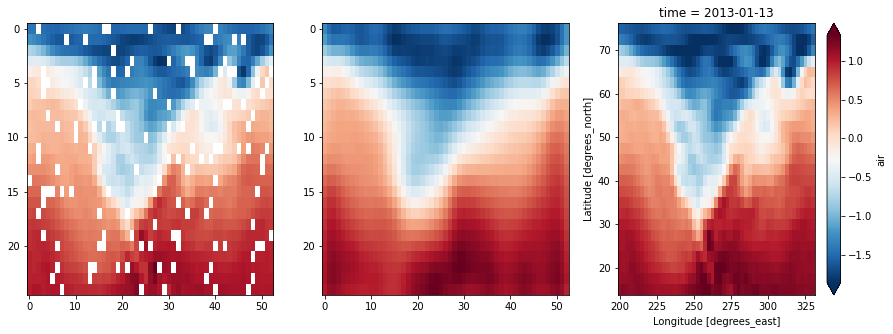

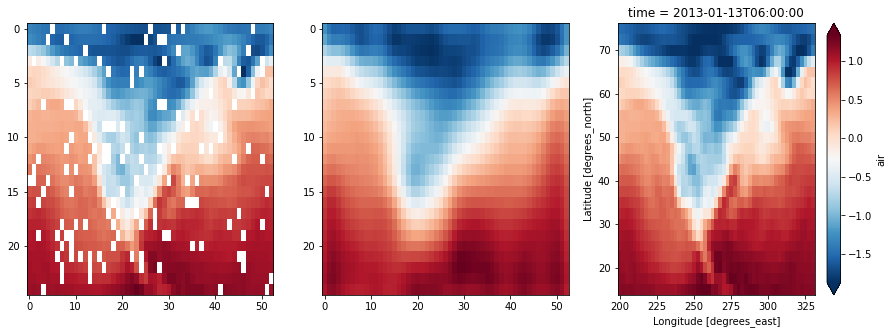

In [47]:
for i in range(len(mu)):

    fig, axes = plt.subplots(ncols=3, figsize=(15,5))
    im = axes[0].imshow(mu_real[i].T[::-1], cmap="RdBu_r", aspect="auto")
    im = axes[1].imshow(mu[i].T[::-1], cmap="RdBu_r", aspect="auto")
    im2 = dat.isel(time=i).plot(ax=axes[2], vmin=mu[i].min(), vmax=mu[i].max(), cmap="RdBu_r")
    # im = axes[0].imshow(mu[i].T[::-1], cmap="RdBu_r", aspect="auto")
    # 
    
    plt.show()


### Flatten

In [168]:
t_flat = np.array(t).flatten()
R_flat = np.array(R).flatten()
Y_flat = np.array(Y_obs).flatten()

In [169]:
t_flat.shape, nt, nt/10

((50,), 50, 5.0)

In [170]:
test_ind.shape, Y_obs.shape

((5,), (50, 1325, 1))

In [164]:
Y_flat.shape, test_ind.shape

((66250,), (5,))

In [171]:
# create random test indices
test_ind = rng.permutation(N)[:N//10]

# subset data
t_test = t_flat[test_ind]
r_test = R_flat[test_ind]
Y_test = Y_flat[test_ind]

Y_flat[test_ind] = np.nan

Y = Y_flat.reshape(nt, n_latlon)

IndexError: index 19787 is out of bounds for axis 0 with size 50

In [161]:
Y_img = Y.reshape((nt, n_lat, n_lon))

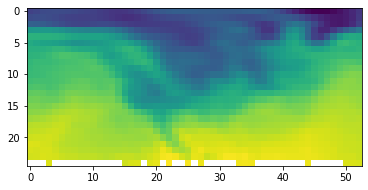

In [162]:
fig, ax = plt.subplots()

ax.imshow(Y_img[0, ::-1, :])

plt.show()

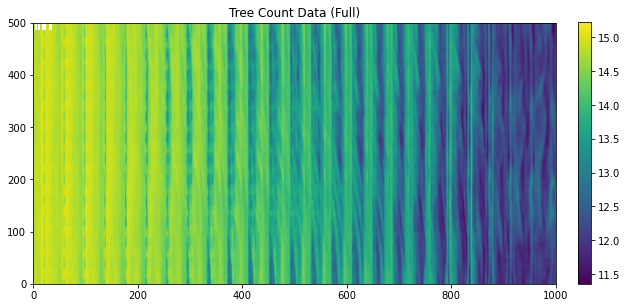

In [139]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y / binsize, extent=[0, 1_000, 0, 500], cmap=cm.viridis)
ax.set(title="Temperature Data (Full)")
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.show()

In [44]:
T.shape, R1.shape, R2.shape

((2920, 1), (2920, 1325, 2), (2920, 1325, 1))

In [28]:
Y = ds.air
time = ds.coords["time"].values
time_steps = np.arange(time.shape[0])
lat = ds.coords["lat"].values
lon = ds.coords["lon"].values

In [33]:
time_steps.shape, lat.shape, lon.shape

((2920,), (25,), (53,))

In [31]:
X = np.vstack([time_steps, lat, lon])

print(X.shape, Y.shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2920 and the array at index 1 has size 25

#### Viz - Basemap

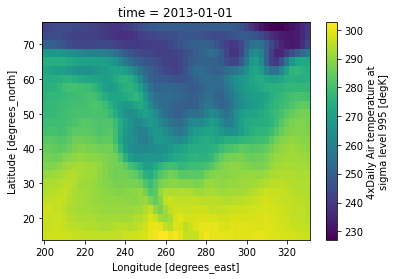

In [12]:
ds.air[0].plot()

#### Viz - Time Series


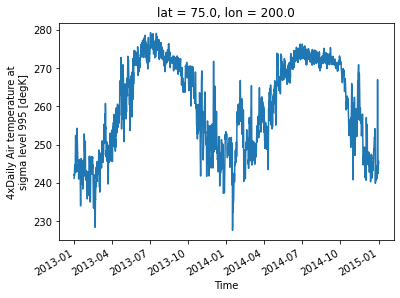

In [13]:
ds.air[:, 0, 0].plot()

### ROMS Model

In [14]:
%%time

ds = xr.tutorial.open_dataset("ROMS_example").load()


CPU times: user 357 ms, sys: 108 ms, total: 465 ms
Wall time: 1.94 s


In [15]:
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 -0.933 -0.8092 -0.6988 ... -0.0005206 -5.758e-05
    lon_rho     (eta_rho, xi_rho) float64 -93.6 -93.58 -93.57 ... -88.88 -88.87
    hc          float64 20.0
    h           (eta_rho, xi_rho) float64 612.1 610.9 609.7 ... 5.0 5.0 5.0
    lat_rho     (eta_rho, xi_rho) float64 27.45 27.45 27.45 ... 30.85 30.86
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 34.95 34.96 ... nan
    zeta        (ocean_time, eta_rho, xi_rho) float32 -0.1565 -0.1553 ... nan
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

### Viz - Gridded

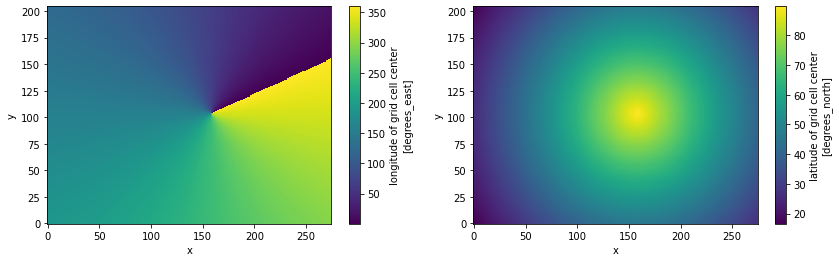

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
ds.xc.plot(ax=ax1)
ds.yc.plot(ax=ax2)

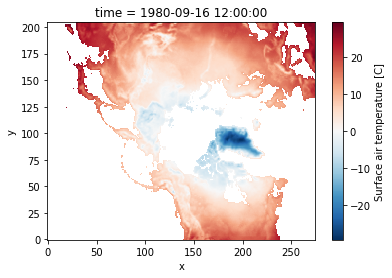

In [6]:
ds.Tair[0].plot()